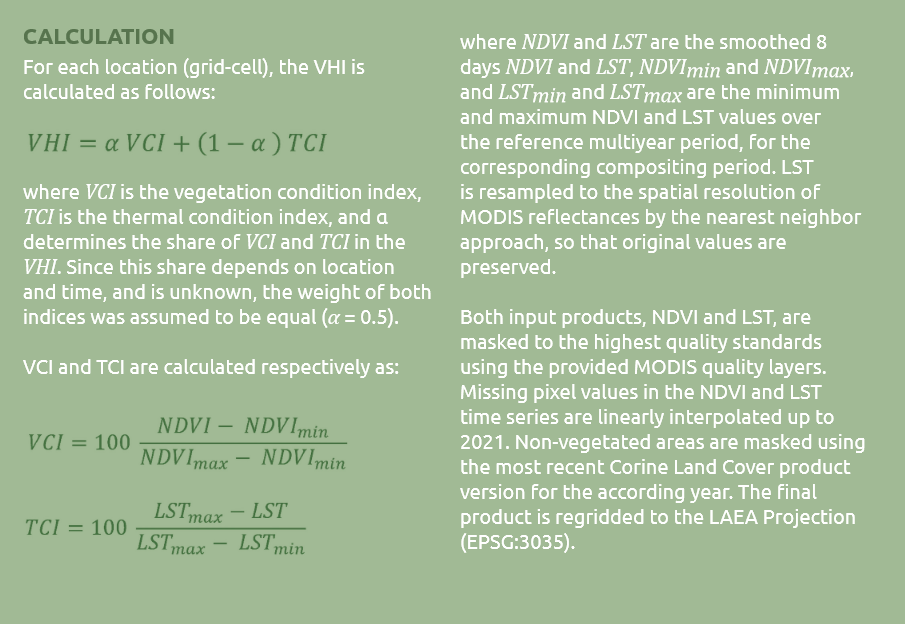

In [1]:
from openeo.local import LocalConnection

conn = LocalConnection("./")

### VCI

We need to compute the minimum and maximum NDVI over the time series

In [2]:
spatial_extent = {
          "west": 13.3652612,
          "east": 16.5153015,
          "south": 45.4236367,
          "north": 46.8639623
        }

temporal_extent = ["2020-06-01","2020-07-01"]
bands = ["red","nir","scl"]
s2_cube = conn.load_stac(url="https://earth-search.aws.element84.com/v1/collections/sentinel-2-l2a",
                              spatial_extent=spatial_extent,
                              temporal_extent=temporal_extent,
                              bands=bands).resample_spatial(resolution=0.25, projection="EPSG:4326")
## TODO: the next metadata steps are necessary due to missing auto extraction of metadata when using load_stac
s2_cube.metadata = s2_cube.metadata.add_dimension("time", label=None, type="temporal")
s2_cube.metadata = s2_cube.metadata.add_dimension("latitude", label=None, type="spatial")
s2_cube.metadata = s2_cube.metadata.add_dimension("longitude", label=None, type="spatial")
s2_cube = s2_cube.rename_dimension(source="latitude",target="lat").rename_dimension(source="longitude",target="lon")
scl = s2_cube.band("scl")
vegetation_mask = (scl == 4)
s2_cube_masked = s2_cube.filter_bands(["red","nir"]).mask(vegetation_mask)

B04 = s2_cube_masked.band("red")
B08 = s2_cube_masked.band("nir")
ndvi = (B08 - B04) / (B08 + B04)

In [3]:
ndvi_max = ndvi.reduce_dimension(dimension="time",reducer="max").add_dimension(name="bands",type="bands",label="NDVI_MAX")
ndvi_min = ndvi.reduce_dimension(dimension="time",reducer="min").add_dimension(name="bands",type="bands",label="NDVI_MIN")
ndvi_min_max = ndvi_max.merge_cubes(ndvi_min)

In [4]:
aggregated_ndvi = ndvi.aggregate_temporal_period("month",reducer="max")
ndvi_min = ndvi_min_max.band("NDVI_MIN")
ndvi_max = ndvi_min_max.band("NDVI_MAX")

diff = ndvi_max - ndvi_min

VCI = aggregated_ndvi.merge_cubes(ndvi_min,overlap_resolver="subtract").merge_cubes(diff,overlap_resolver="divide").add_dimension(name="bands",type="bands",label="value")

In [5]:
VCI.execute()

/home/mclaus@eurac.edu/anaconda3/envs/stac_310/lib/python3.10/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(
/home/mclaus@eurac.edu/anaconda3/envs/stac_310/lib/python3.10/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(


<xarray.DataArray (bands: 1, time: 1, lat: 5, lon: 13)> Size: 520B
dask.array<broadcast_to, shape=(1, 1, 5, 13), dtype=float64, chunksize=(1, 1, 5, 13), chunktype=numpy.ndarray>
Coordinates:
  * lat          (lat) float64 40B 46.62 46.38 46.12 45.88 45.62
  * lon          (lon) float64 104B 13.38 13.62 13.88 ... 15.88 16.12 16.38
    spatial_ref  int32 4B 4326
  * time         (time) datetime64[ns] 8B 2020-06-30
  * bands        (bands) <U5 20B 'value'
Attributes:
    reduced_dimensions_min_values:  {'bands': 'nir'}

### TCI - Thermal Condition Index

We need to compute the minimum and maximum temperature over the time series

In [6]:
spatial_extent = {
          "west": 13.3652612,
          "east": 16.5153015,
          "south": 45.4236367,
          "north": 46.8639623
        }

temporal_extent = ["2020-01-01","2020-12-31"]
bands = ["air_temperature_at_2_metres"]
era5 = conn.load_stac(url="https://planetarycomputer.microsoft.com/api/stac/v1/collections/era5-pds",
                              spatial_extent=spatial_extent,
                              temporal_extent=temporal_extent,
                              bands=bands,
                              properties={"era5:kind": {"eq": "an"}})

t_max = era5.max_time().rename_labels(dimension="bands",target=["T_MAX"])
t_min = era5.min_time().rename_labels(dimension="bands",target=["T_MIN"])
t_min_max = t_max.merge_cubes(t_min)

Now that we have the yearly min and max values for the temperature, we can compute the TCI for a specific time range, the one for which we want to compute the VHI.

In [7]:
temporal_extent = ["2020-06-01","2020-07-01"]

era5 = conn.load_stac(url="https://planetarycomputer.microsoft.com/api/stac/v1/collections/era5-pds",
                              spatial_extent=spatial_extent,
                              temporal_extent=temporal_extent,
                              bands=bands,
                              properties={"era5:kind": {"eq": "an"}}).drop_dimension("bands")
era5_monthly_mean = era5.aggregate_temporal_period(period="month",reducer="mean")

t_min = t_min_max.band("T_MIN")
t_max = t_min_max.band("T_MAX")

In [8]:
TCI = (((era5_monthly_mean * -1) + t_max) / (t_max - t_min)) * 100
TCI_aligned = TCI.resample_cube_spatial(target=VCI).add_dimension(name="bands",type="bands",label="value")
## TODO: apparently merge_cubes doesn't work if there is no bands dimension.
## Moreover, it should automatically perform resample_cubes_spatial if necessary

In [9]:
TCI_aligned.execute()

<xarray.DataArray 'reproject-13ea4214c23a45979f744acd2c6a4e0b' (bands: 1,
                                                                time: 1,
                                                                lat: 5, lon: 13)> Size: 260B
dask.array<broadcast_to, shape=(1, 1, 5, 13), dtype=float32, chunksize=(1, 1, 5, 13), chunktype=numpy.ndarray>
Coordinates:
  * time         (time) datetime64[ns] 8B 2020-06-30
  * lat          (lat) float64 40B 46.62 46.38 46.12 45.88 45.62
  * lon          (lon) float64 104B 13.38 13.62 13.88 ... 15.88 16.12 16.38
    spatial_ref  int64 8B 0
  * bands        (bands) <U5 20B 'value'

### VHI - Vegetation Health Index

Combine the VCI and TCI indexes to compute VHI

In [10]:
alpha = 0.5

VHI = alpha * VCI + (1 - alpha) * TCI_aligned
VHI

In [11]:
VHI.execute()

<xarray.DataArray (bands: 1, time: 1, lat: 5, lon: 13)> Size: 520B
dask.array<add, shape=(1, 1, 5, 13), dtype=float64, chunksize=(1, 1, 5, 13), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 40B 46.62 46.38 46.12 45.88 45.62
  * lon      (lon) float64 104B 13.38 13.62 13.88 14.12 ... 15.88 16.12 16.38
  * time     (time) datetime64[ns] 8B 2020-06-30
  * bands    (bands) <U5 20B 'value'